In [267]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7507495937633137720
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9645652048113706285
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [268]:
import os
import shutil
import random

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()

model_number = 1
dataset_path = '../cropped_images'

# 데이터셋 경로 설정
base_dir = os.path.join(current_dir, dataset_path)
model_dir = os.path.join(current_dir, 'model_'+ str(model_number))
train_dir = os.path.join(model_dir, 'train')
validation_dir = os.path.join(model_dir, 'validation')

os.makedirs(model_dir, exist_ok=True)

# 폴더 비우기 함수 정의
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

# 폴더 초기화
clear_directory(train_dir)
clear_directory(validation_dir)

# 폴더명을 통해 전체 클래스 리스트 가져오기
all_classes = sorted(os.listdir(base_dir))

# 원하는 수의 클래스 선택 (예: 10개, 20개)
num_classes = 20  # 또는 10으로 변경 가능
selected_classes = all_classes[:num_classes]

# 각 클래스당 사용할 이미지 수
default_num_images_per_class = 100

# 각 클래스당 사용할 학습:검증의 비율
train_valid_rate = 0.7

for class_name in selected_classes:
    class_dir = os.path.join(base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(validation_dir, class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    
    images = os.listdir(class_dir)
    num_images_per_class = min(default_num_images_per_class, len(images))
    random.shuffle(images)
    
    train_split = int(train_valid_rate * num_images_per_class)
    
    train_images = images[:train_split]
    val_images = images[train_split:num_images_per_class]
    
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_class_dir, image)
        shutil.copyfile(src, dst)
    
    for image in val_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_class_dir, image)
        shutil.copyfile(src, dst)


In [269]:
selected_classes

['dog0',
 'dog1',
 'dog2',
 'dog3',
 'dog4',
 'dog5',
 'dog6',
 'dog7',
 'dog8',
 'dog9']

In [270]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 설정
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=selected_classes,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=selected_classes,
    class_mode='categorical')

Found 67 images belonging to 10 classes.
Found 35 images belonging to 10 classes.


In [271]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.regularizers import l2


# 사전 훈련된 MobileNet 모델 불러오기 (출력층 제외)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.6)(x)  # 드롭아웃 추가
predictions = Dense(len(selected_classes), activation='softmax')(x)  # 클래스 수에 맞게 조정

# 새로운 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 기본 모델의 가중치를 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

In [272]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
4/4 [==============================] - 2s 288ms/step - loss: 2.7178 - accuracy: 0.2969 - val_loss: 1.4309 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 0s 120ms/step - loss: 2.2425 - accuracy: 0.4510 - val_loss: 0.4763 - val_accuracy: 0.9688
Epoch 3/50
4/4 [==============================] - 0s 102ms/step - loss: 1.4690 - accuracy: 0.5294 - val_loss: 0.7238 - val_accuracy: 0.8125
Epoch 4/50
4/4 [==============================] - 0s 123ms/step - loss: 0.9433 - accuracy: 0.6875 - val_loss: 0.2826 - val_accuracy: 0.9062
Epoch 5/50
4/4 [==============================] - 0s 119ms/step - loss: 0.5382 - accuracy: 0.8824 - val_loss: 0.5466 - val_accuracy: 0.8125
Epoch 6/50
4/4 [==============================] - 0s 114ms/step - loss: 0.7957 - accuracy: 0.7812 - val_loss: 0.4799 - val_accuracy: 0.8125
Epoch 7/50
4/4 [==============================] - 0s 120ms/step - loss: 0.5306 - accuracy: 0.8235 - val_loss: 0.1421 - val_accuracy: 0.9375
Epoch 8/50
4/4 [====

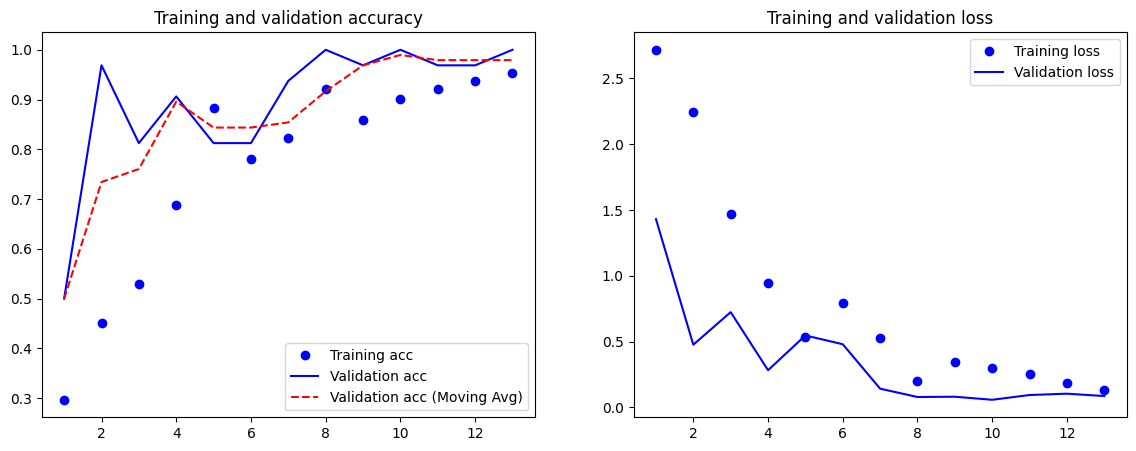

In [273]:
import matplotlib.pyplot as plt
import numpy as np

def adjusted_moving_average(data, window_size):
    averages = []
    for i in range(len(data)):
        if i < window_size - 1:
            averages.append(np.mean(data[:i+1]))
        else:
            averages.append(np.mean(data[i-window_size+1:i+1]))
    return np.array(averages)

def drawAccuracyGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # 검증 정확도의 조정된 이동 평균 계산
    window_size = 3
    val_acc_moving_avg = adjusted_moving_average(val_acc, window_size)

    plt.figure(figsize=(14, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, val_acc_moving_avg, 'r--', label='Validation acc (Moving Avg)')  # 조정된 이동 평균 추가
    plt.title('Training and validation accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

drawAccuracyGraph(history)


### 

In [274]:
epochs = len(history.history['accuracy'])
last_acc = history.history['accuracy'][-1]
last_val_acc = history.history['val_accuracy'][-1]

log_text_path = "test_result.md"

with open(log_text_path, "a") as f:
    data = f"""# {'model_'+str(model_number)}\n
* 학습 데이터: {dataset_path}
* 개체수: {len(selected_classes)}
* 학습 모델: {base_model.name}
* 데이터 분할 비율: {round(train_valid_rate*10)}:{round((1-train_valid_rate)*10)}
* 배치 사이즈: {train_generator.batch_size}
* 반복 횟수: {epochs}
* 훈련 정확도: {last_acc}
* 검증 정확도: {last_val_acc}
    """
    f.write(data + "\n")

### 파라미터 및 클래스명 저장

In [275]:
model.save('my_model.h5')

import json

# 클래스 목록 가져오기
class_indices = train_generator.class_indices
selected_classes = list(class_indices.keys())
print("Class indices:", class_indices)
print("Selected classes:", selected_classes)

# JSON 파일로 저장
with open('class_names.json', 'w') as f:
    json.dump(selected_classes, f)

Class indices: {'dog0': 0, 'dog1': 1, 'dog2': 2, 'dog3': 3, 'dog4': 4, 'dog5': 5, 'dog6': 6, 'dog7': 7, 'dog8': 8, 'dog9': 9}
Selected classes: ['dog0', 'dog1', 'dog2', 'dog3', 'dog4', 'dog5', 'dog6', 'dog7', 'dog8', 'dog9']


In [280]:
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input

# 모델 로드
model = load_model('my_model.h5')

# 클래스 이름 JSON 파일에서 불러오기
with open('class_names.json', 'r') as f:
    selected_classes = json.load(f)

# 예측할 이미지 파일 경로
image_path = "../test_img/9/dog9 (2).jpg"

# 이미지 로드 및 전처리
image = Image.open(image_path)
image = image.resize((224, 224))
image_array = np.array(image)
image_array = preprocess_input(image_array)  # MobileNet 전처리 함수 사용
image_array = np.expand_dims(image_array, axis=0)

# 모델 예측
predictions = model.predict(image_array)

# 상위 3개의 예측 결과 찾기
top_indices = predictions[0].argsort()[-3:][::-1]
top_classes = [selected_classes[i] for i in top_indices]
top_probabilities = [predictions[0][i] for i in top_indices]

print("Selected classes:", selected_classes)

# 예측 결과 출력
for i in range(3):
    print(f"Top {i+1} predicted class: {top_classes[i]} with probability {top_probabilities[i]:.4f}")

# 전체 예측 결과 출력 (선택사항)
print(f"Predicted class index: {np.argmax(predictions[0])}")
print(f"Predicted class probabilities: {predictions[0]}")


1/1 [==============================] - 0s 282ms/step
Selected classes: ['dog0', 'dog1', 'dog2', 'dog3', 'dog4', 'dog5', 'dog6', 'dog7', 'dog8', 'dog9']
Top 1 predicted class: dog9 with probability 0.5377
Top 2 predicted class: dog8 with probability 0.4128
Top 3 predicted class: dog4 with probability 0.0174
Predicted class index: 9
Predicted class probabilities: [8.9947544e-03 1.0815105e-02 2.9861848e-03 1.5236276e-03 1.7376501e-02
 3.8111166e-04 5.9315318e-04 6.8304120e-03 4.1283098e-01 5.3766817e-01]


1/1 [==============================] - 0s 15ms/step


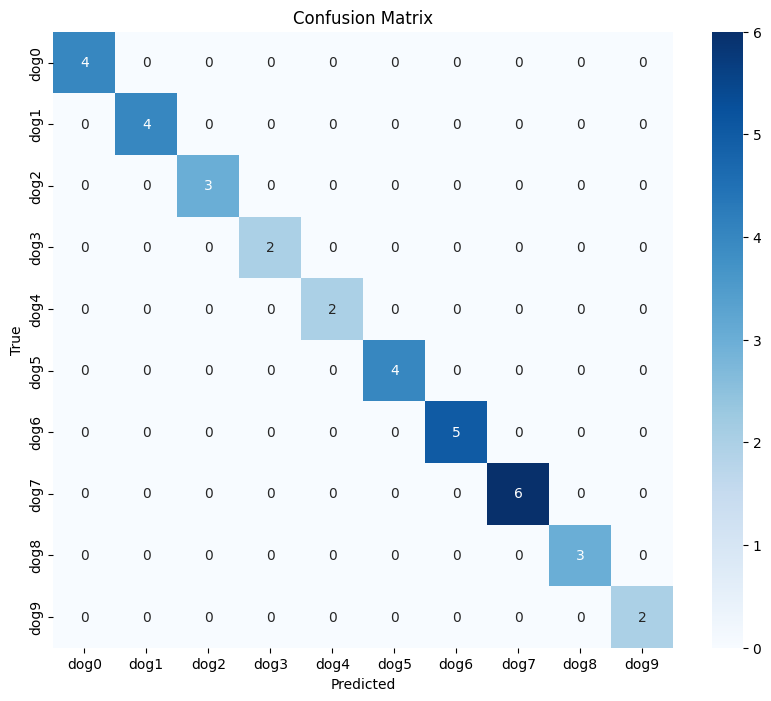

In [277]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 검증 데이터에 대한 예측 수행
y_true = []
y_pred = []

validation_generator.reset()
for _ in range(len(validation_generator)):
    images, labels = validation_generator.next()
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

# 클래스 이름 가져오기
class_names = list(validation_generator.class_indices.keys())

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
